# Тестовое задание к проекту "Trend signals extraction from textual data"
Овчаренко Анатолий, CSC

Март, 2022

С помощью SQL-скрипта `query.sql` в `./data` были выгружены тексты 10000 постов (тело поста, заголовок поста и теги поста) со StackOverflow, опубликованные за последние 6 месяцев.

План работы с текстами:
1. Выполнить очистку текстов от HTML-тегов `<code>` для исключения из учета конструкций кода и сохранения исключительно "печатного" текста;
2. С помощью возможностей библиотеки NLTK выполнить подсчет частот слов:
    1. Разделить тексты на предложения, а те на токены (слова и знаки препинания);
    2. Выполнить подсчет частот токенов, которые являются словами (состоят исключительно из букв) и прошли дополнительный фильтр: слова не входят в набор так называемых стоп-слов (`if’`, `the`, `such`, `so`, ...);
3. Провести визуализацию `n` наиболее часто встречающихся слов с помощью столбчатой диаграммы частот.

Этот план далее выполняется как для всего загруженного корпуса текстов (оценка всеобщей статистики на StackOverflow), так и для текстов, которые отмечены определенным тегом (например, `python`, `javascript`, `sql` и др.) для поиска наиболее часто используемых слов в текстах более-менее фиксированной категории.

Под фразами для простоты далее понимаются N-граммы -- непрерывные подпоследовательности длины N в последовательности слов в предложении. К ним применяются аналогичные фильтрации и так же считаются и визуализируются частоты (глобально и по тегам).

In [1]:
import re
import bs4
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from collections import defaultdict

plt.rcParams["figure.dpi"] = 300

nltk.download("stopwords")
nltk.download("punkt")

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ov4t\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ov4t\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Загрузка и предобработка данных
* Загрузка и очистка текстов
* Поиск самых популярных тегов

In [2]:
POST_TAG_REGEXP = re.compile(r"<([^<>]+)>")


def clean_html_tags(html: str) -> str:
    soup = bs4.BeautifulSoup(html, "html.parser")
    for code in soup("code"):
        code.decompose()
    return soup.text


def get_texts(path: str) -> pd.DataFrame:
    data = pd.read_csv(path).dropna()
    data["text"] = data["text"].apply(clean_html_tags)
    data["title"] = data["title"].apply(clean_html_tags)
    return data


def get_tags_frequences(data: pd.DataFrame) -> defaultdict:
    tags_freq = defaultdict(int)
    for i in range(data.shape[0]):
        for tag in POST_TAG_REGEXP.findall(data.loc[i, "tags"]):
            tags_freq[tag] += 1
    return tags_freq

In [3]:
texts_data = get_texts("./data/posts.csv")
texts_data.head(20)

,text,title,tags
0,I want remove special character from column.\...,Remove special character from customerId colum...,<sql-server><azure-data-factory>
1,Few days ago i have updated my windows to 11 v...,Windows 11 and skype meetings web version,<skype-for-business><windows-11>
2,I use IDEA IDE (PhpStorm). My regular pattern ...,"IDEA IDE: Text cursor movement after ""select all""",<intellij-idea><user-experience><editing><usab...
3,Front\nMySQL version: 5.7.36\ntransaction_isol...,Holding an MDL read lock will block the MDL wr...,<mysql><block>
4,Ad-mob test ads is not showing on one of my a...,Admob test ads is not showing on a specific ap...,<android><android-studio><admob>
5,I am new to SQL and I want to add/subtract the...,How can I add/subtract the offset value into d...,<sql><sql-server>
6,I have this website were we can create new que...,how to make google bots crawl my react website...,<reactjs><express><sitemap><xml-sitemap>
7,I got a JSON string value :\n\nI want to chang...,Add array tag into JSON string value using c#,<c#><asp.net><json><.net>
8,"As the title says, I have 2 seperate servers a...",Can 2 Debezium Connectors read from same sourc...,<apache-kafka><debezium>
9,"I have 2 screens A and B, in screen A I have a...",How to keep the value of textinput when going ...,<android><ios><reactjs><react-native><react-ho...


In [4]:
all_tags_freq = get_tags_frequences(texts_data)
print(f"Количество различных найденных тегов: {len(all_tags_freq)}")

most_frequent_tags = sorted(all_tags_freq, key=lambda t: all_tags_freq[t], reverse=True)[:10]
print("Первые самые часто встречающиеся теги:")
most_frequent_tags

Количество различных найденных тегов: 5963
Первые самые часто встречающиеся теги:


['python',
 'javascript',
 'reactjs',
 'java',
 'html',
 'c#',
 'android',
 'node.js',
 'css',
 'php']

## Наиболее часто употребимые слова

In [5]:
STOP_WORDS = set(nltk.corpus.stopwords.words("english"))


def get_most_frequent(fdist: nltk.FreqDist, n: int) -> list:
    return fdist.most_common(n)


def draw_words_bar(words_with_freq: list, title: str):
    n = len(words_with_freq)
    
    plt.figure(figsize=(16, 7))
    plt.bar([pair[0] for pair in words_with_freq], [pair[1] for pair in words_with_freq])
    plt.xticks(rotation=70, ha="right", rotation_mode="anchor")
    plt.grid(axis="y")
    plt.title(title)
    
    plt.show()

### Самые часто используемые слова (статистика по всему корпусу текстов -- без деления на теги)

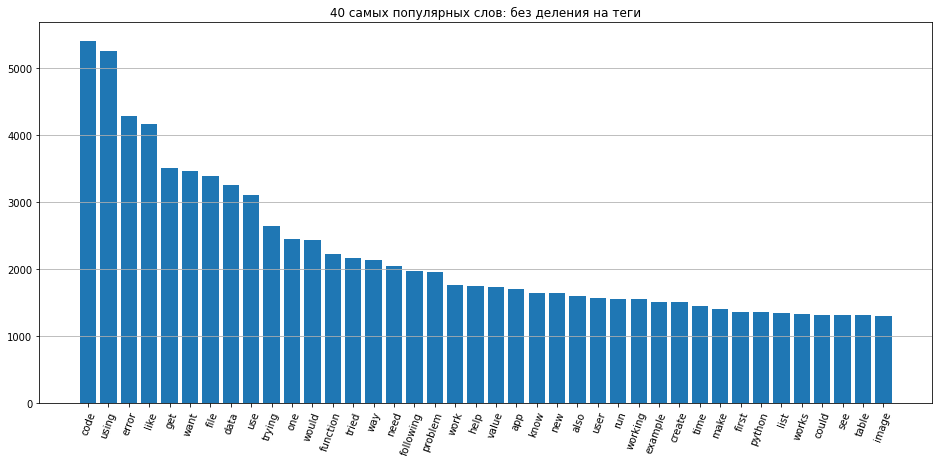

In [6]:
n = 40
fdist = nltk.FreqDist(
    w
    for _, row in texts_data.iterrows()
    for word in nltk.tokenize.word_tokenize(row["title"] + "\n" + row["text"])
    if (w := word.lower()) not in STOP_WORDS and w.isalpha()
)
draw_words_bar(get_most_frequent(fdist, n), f"{n} самых популярных слов: без деления на теги")

Как видно, при отсутствии деления текстов на теги в топе самых популярных слов преобладают слова общего характера, не относящиеся к какой-то специфике, связанной с программированием. Хотя уже даже в такой статистике можно углядеть тренд популярности языка Python: в топе имеются слова `Python`, `list`.

### Самые часто используемые слова с делением по тегам

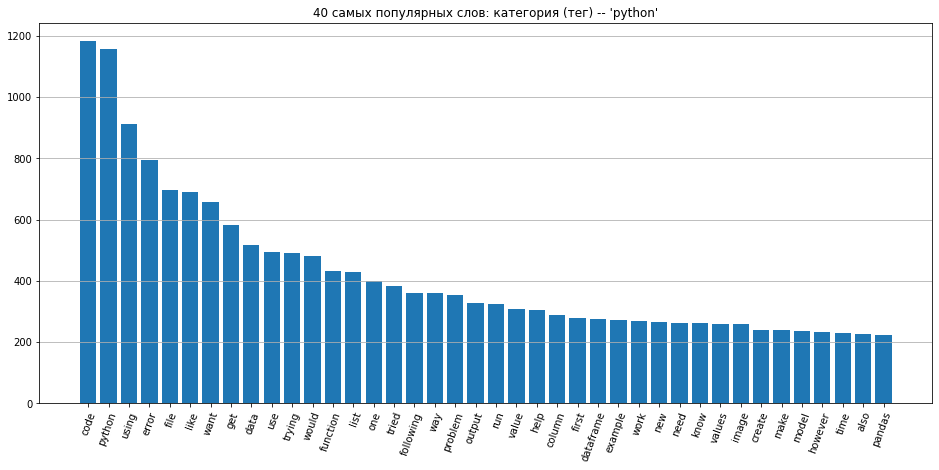

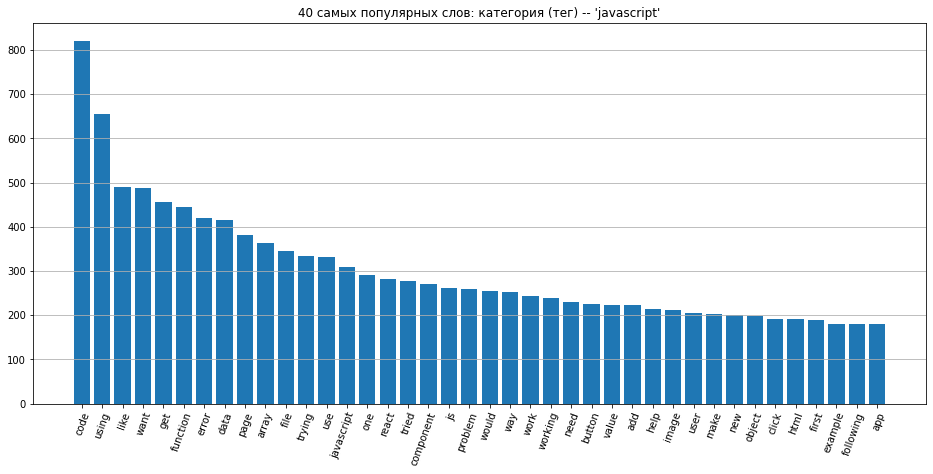

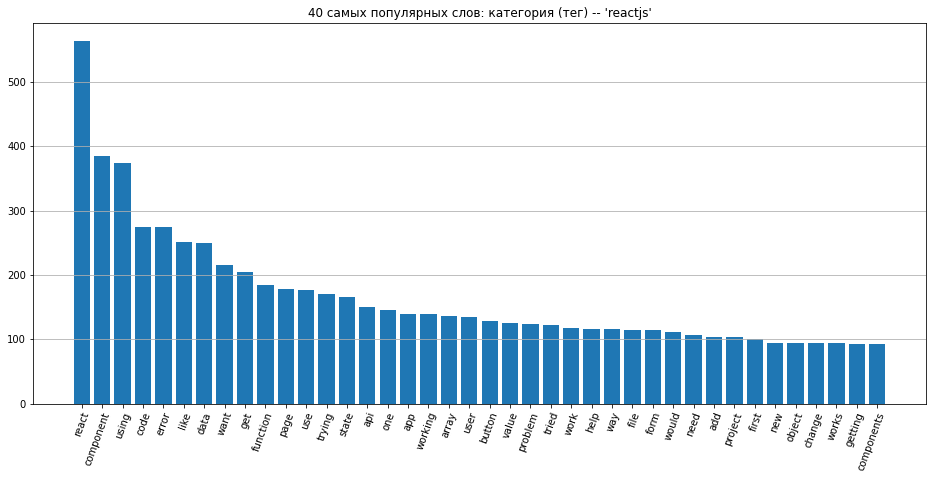

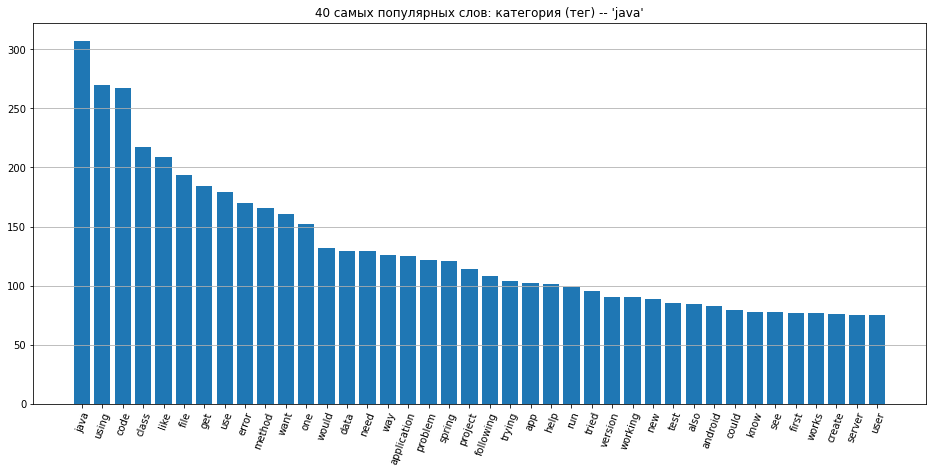

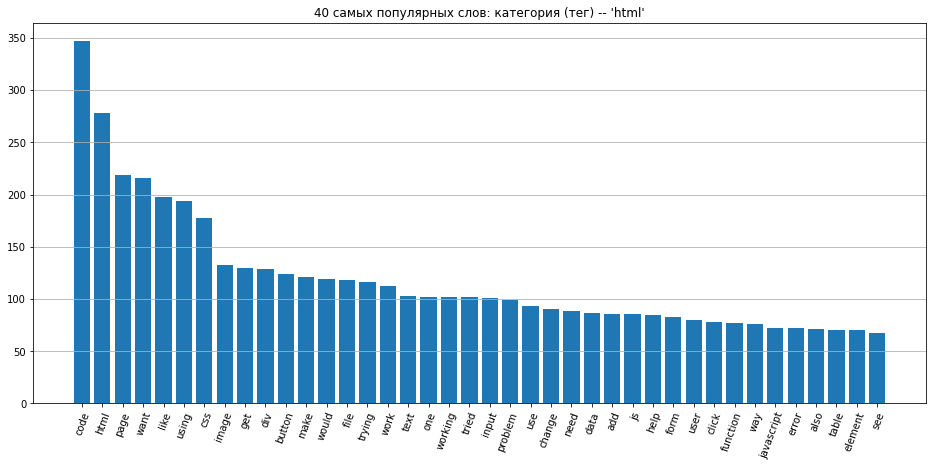

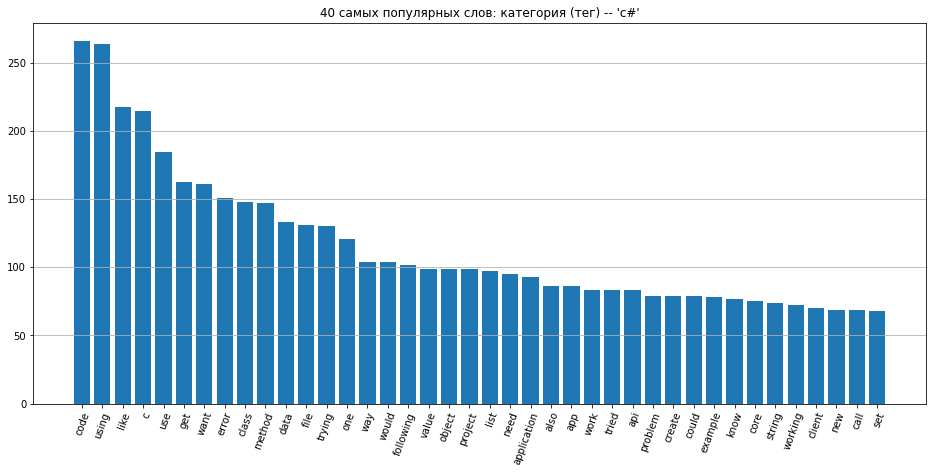

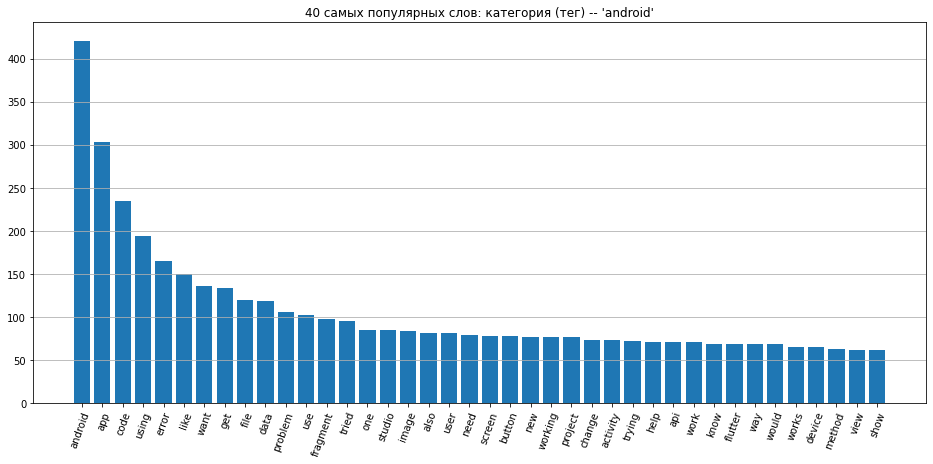

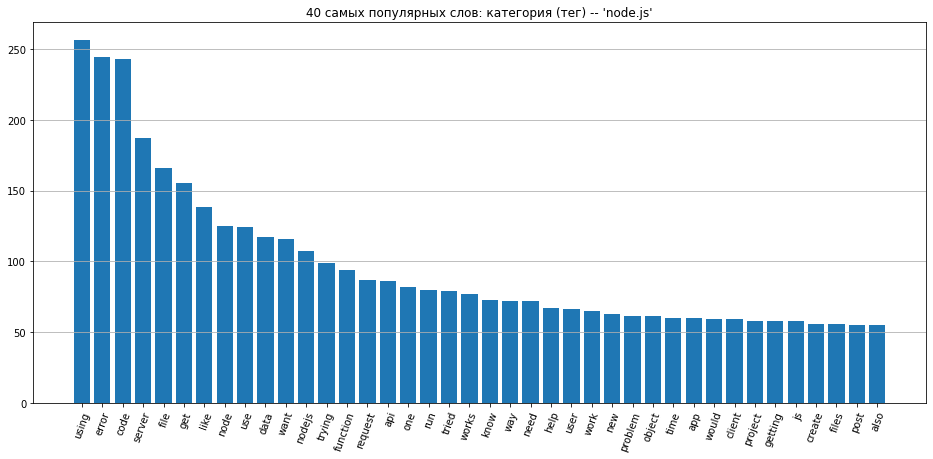

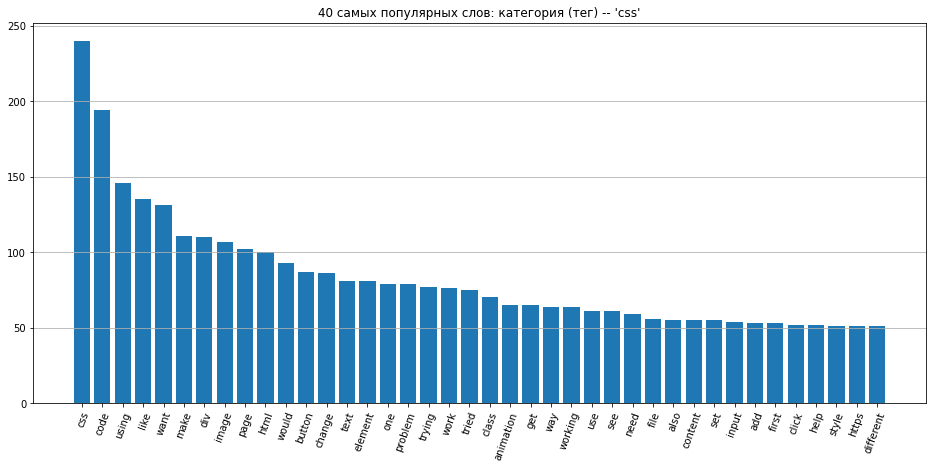

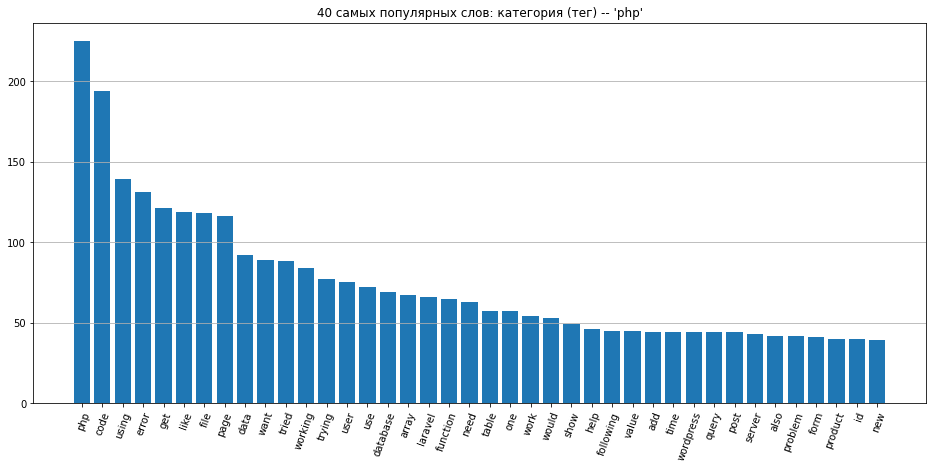

In [7]:
def get_tagged_words_freq(tag: str, data: pd.DataFrame) -> nltk.FreqDist:
    formatted_tag = f"<{tag}>"
    return nltk.FreqDist(
        w
        for _, row in texts_data.iterrows()
        for word in nltk.tokenize.word_tokenize(row["title"] + "\n" + row["text"])
        if (w := word.lower()) not in STOP_WORDS and w.isalpha()
        and formatted_tag in row["tags"]
    )


n = 40
for tag in most_frequent_tags:
    fdist = get_tagged_words_freq(tag, texts_data)
    draw_words_bar(get_most_frequent(fdist, n), f"{n} самых популярных слов: категория (тег) -- '{tag}'")

Итак, разделение текстов по тегам и подсчет частот с таким разделением значительно проясняет картину: топы слов теперь содержат намного больше специфических слов, присущих данному тегу. Такая информация позволяет сделать прикидку, что же за последние 6 месяцев больше всего волнует пользователей StackOverflow. Так, например:
1. В теге `python` в топ входят слова, связанные с библиотекой `Pandas` (`pandas`, `dataframe`, `data`) -- это наиболее популярная в `Python` библиотека для работы с табличными данными, что сегодня актуально в области анализа данных и машинного обучения;
2. В теге `javascript` в топ входят слова, связанные с фреймворком `ReactJS` (`react`, `component`), что говорит о его большой популярности по сравнению с другими фреймворками;
3. В теге `java` имеют место слова, связанные с бэкенд-разработкой (`server`, `user`), а также с разработкой под Android.

Указанный список наблюдений можно продолжать и дальше, исследуя полученные топы

## Наиболее часто употребимые фразы
* Самые популярные 2-граммы (глобально и по тегам)
* Самые популярные 3-граммы (глобально и по тегам)

### 2-граммы

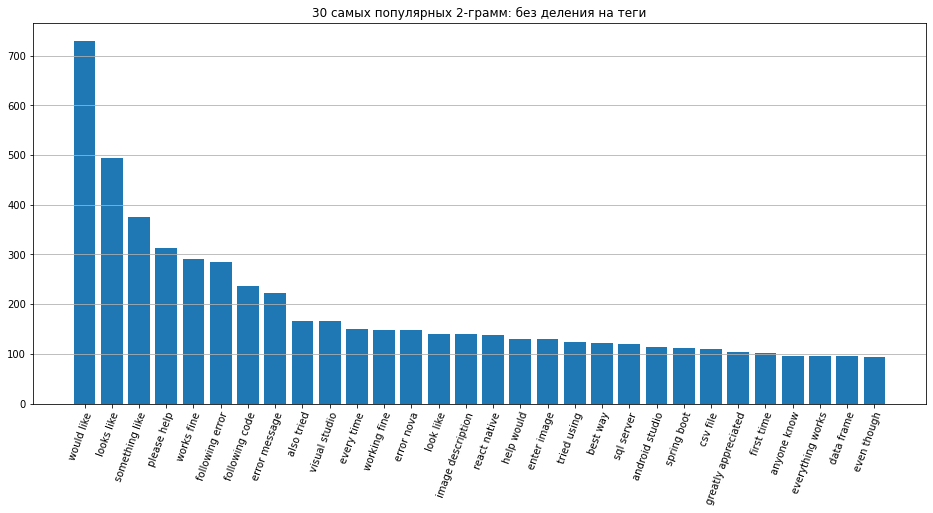

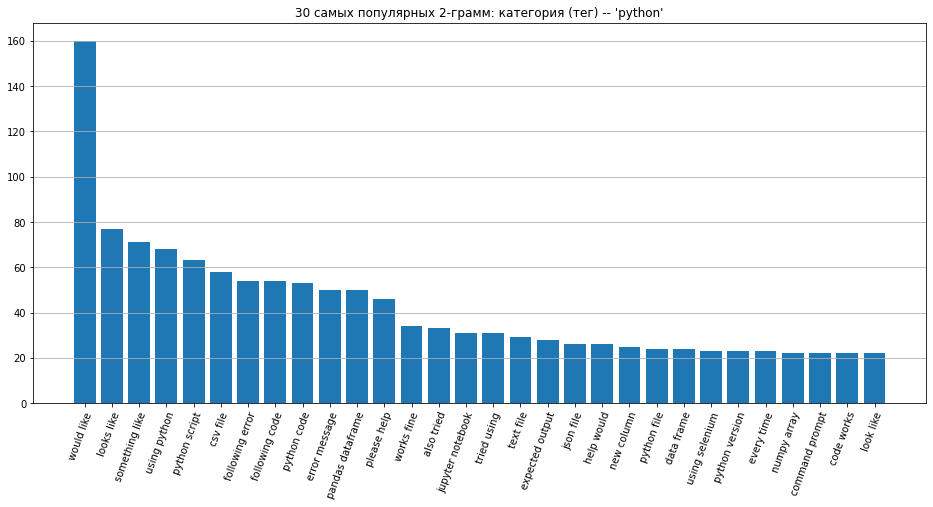

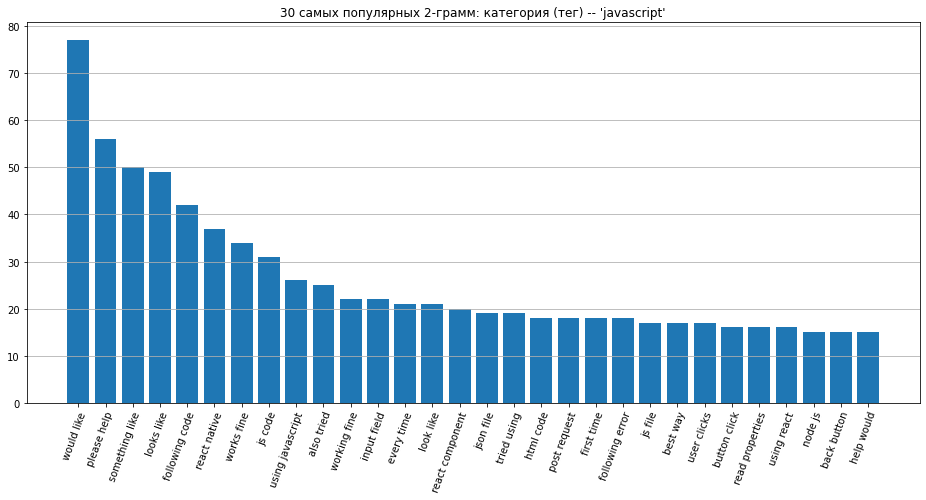

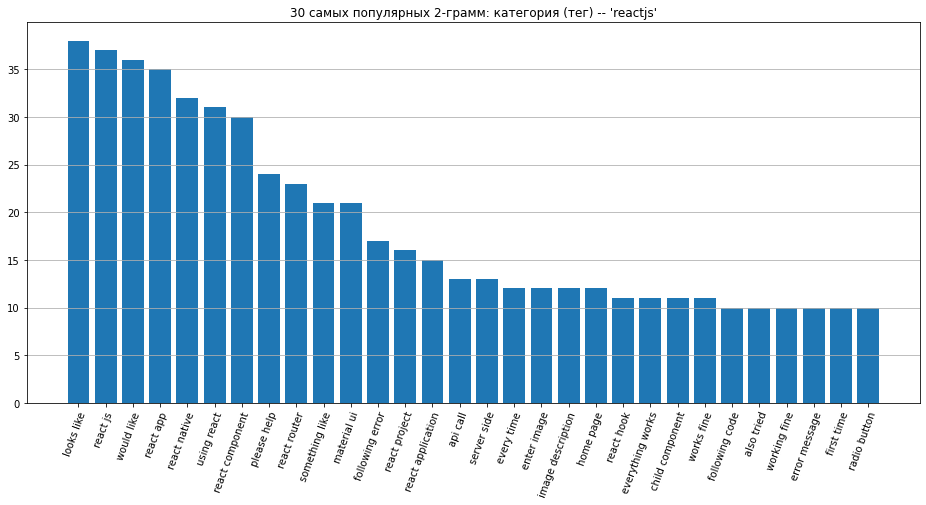

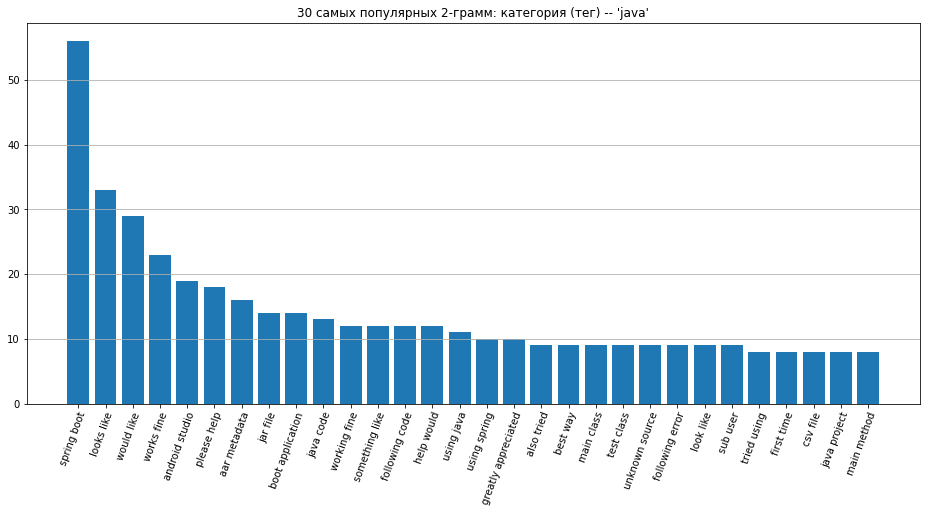

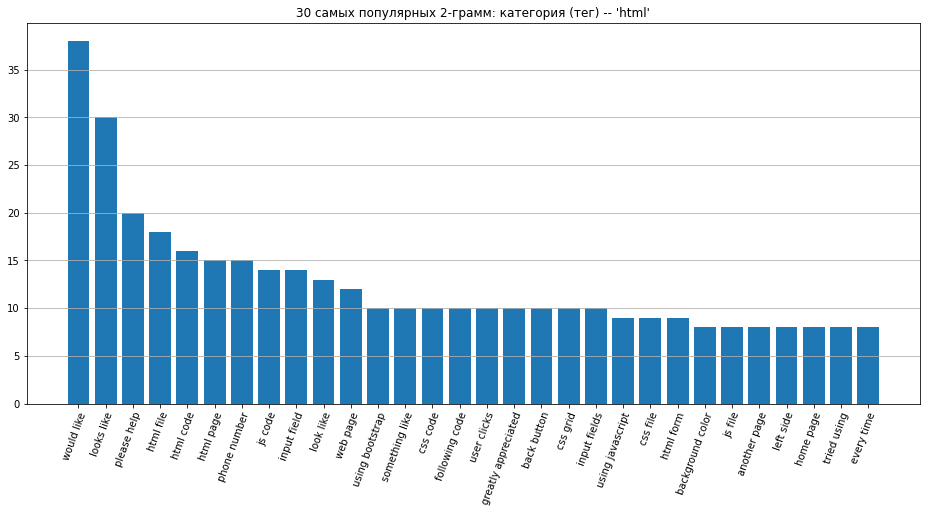

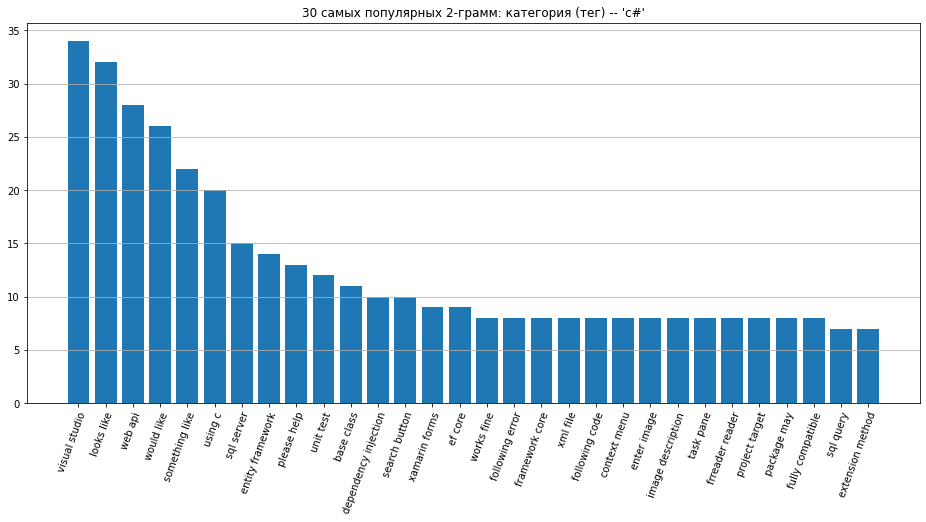

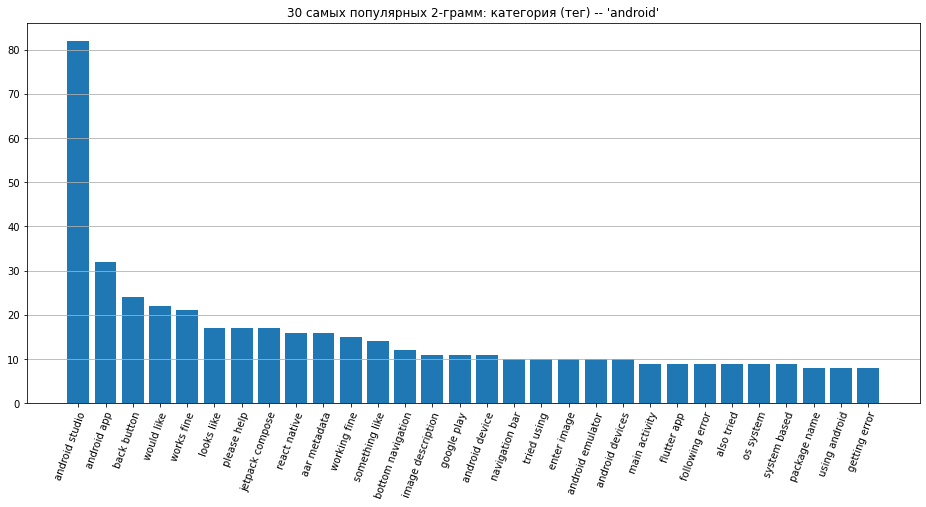

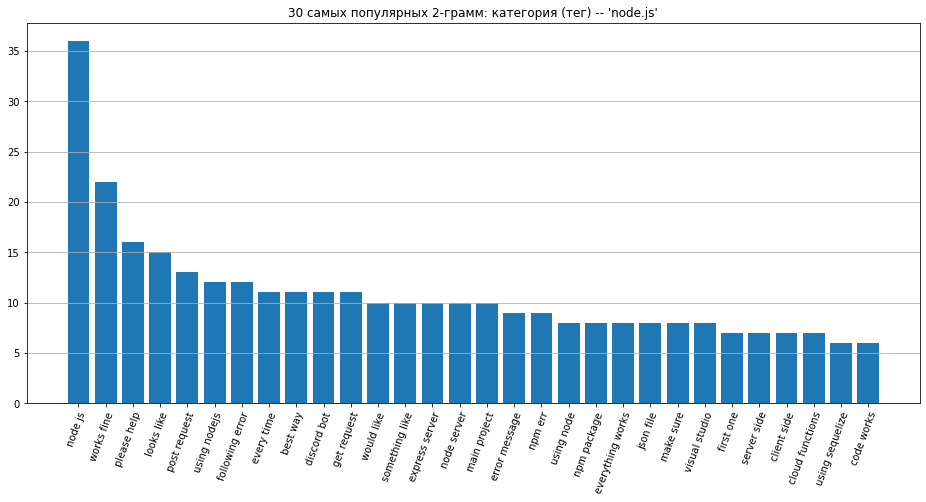

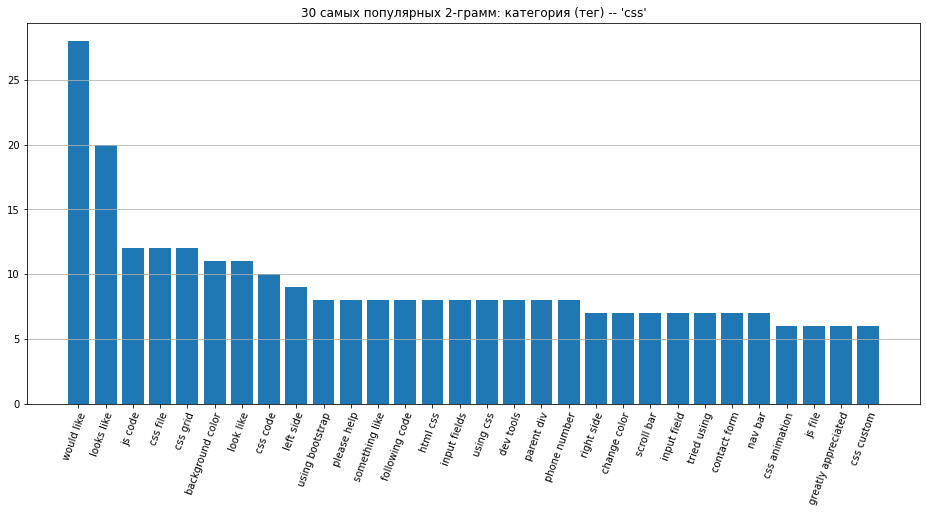

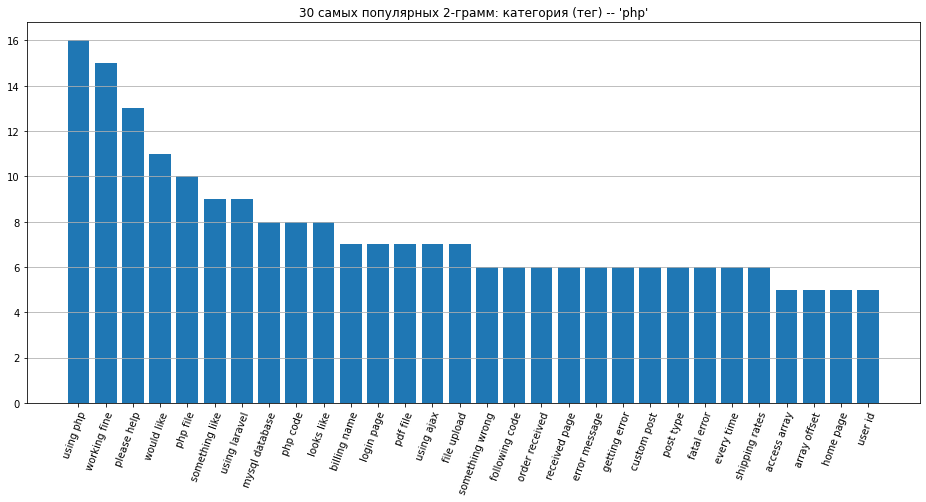

In [8]:
def get_tagged_Ngramms_freq(tag: str, data: pd.DataFrame, N: int) -> nltk.FreqDist:
    formatted_tag = f"<{tag}>"
    fdist = nltk.FreqDist(
        " ".join(ngram_lower)
        for _, row in texts_data.iterrows()
        for ngram in nltk.ngrams(nltk.tokenize.word_tokenize(row["title"] + "\n" + row["text"]), N)
        if not set(ngram_lower := [w.lower() for w in ngram]) & STOP_WORDS
        and all(w.isalpha() for w in ngram_lower) and formatted_tag in row["tags"]
    )
    return fdist

N = 2
fdist = nltk.FreqDist(
    " ".join(ngram_lower)
    for _, row in texts_data.iterrows()
    for ngram in nltk.ngrams(nltk.tokenize.word_tokenize(row["title"] + "\n" + row["text"]), N)
    if not set(ngram_lower := [w.lower() for w in ngram]) & STOP_WORDS
    and all(w.isalpha() for w in ngram_lower)
)
n = 30
draw_words_bar(get_most_frequent(fdist, n), f"{n} самых популярных {N}-грамм: без деления на теги")
for tag in most_frequent_tags:
    fdist = get_tagged_Ngramms_freq(tag, texts_data, N)
    draw_words_bar(get_most_frequent(fdist, n), f"{n} самых популярных {N}-грамм: категория (тег) -- '{tag}'")

### 3-граммы

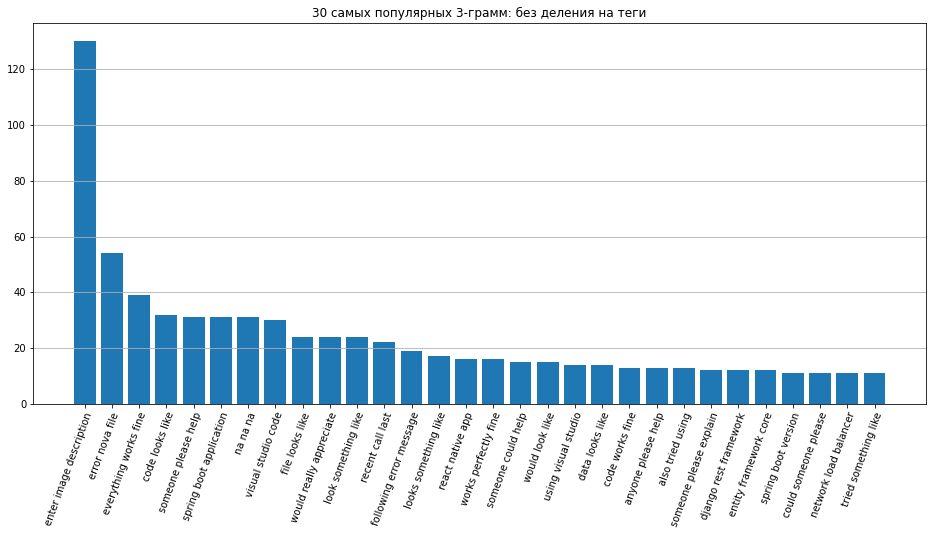

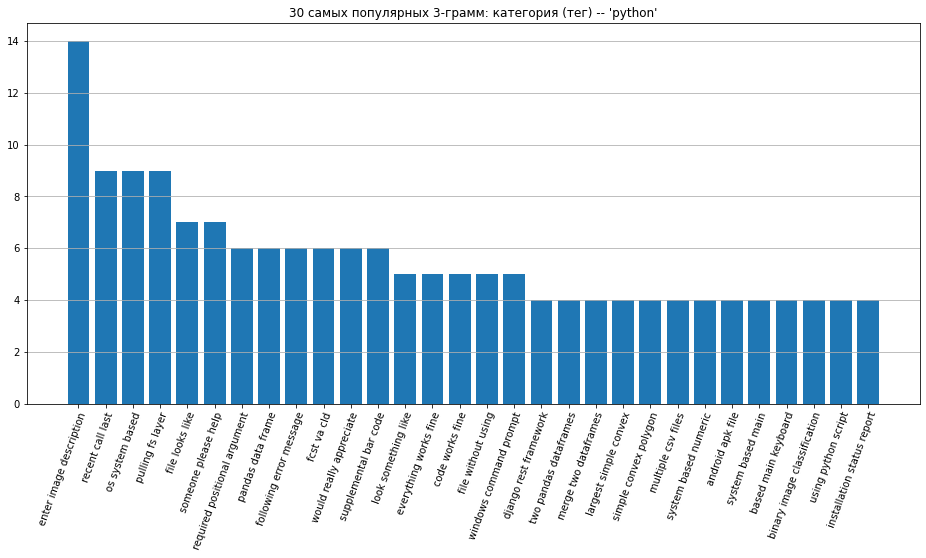

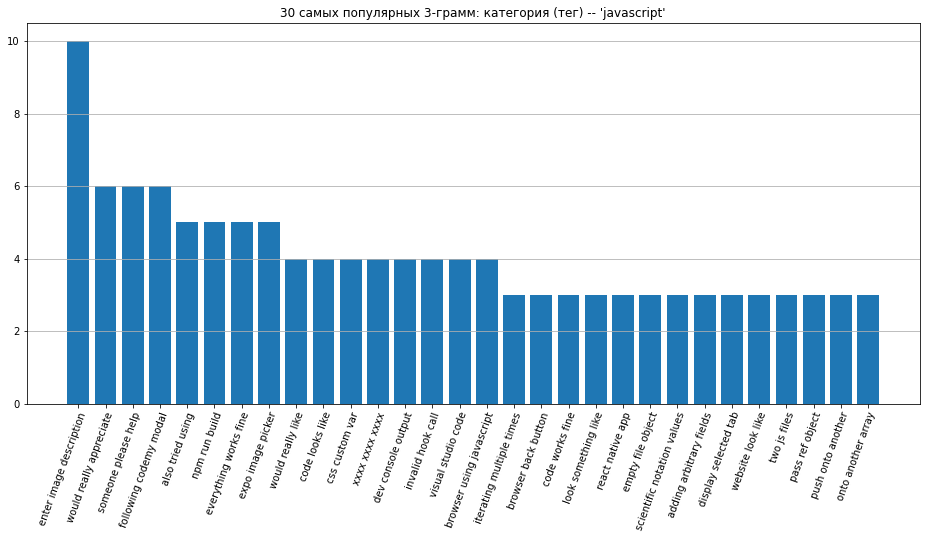

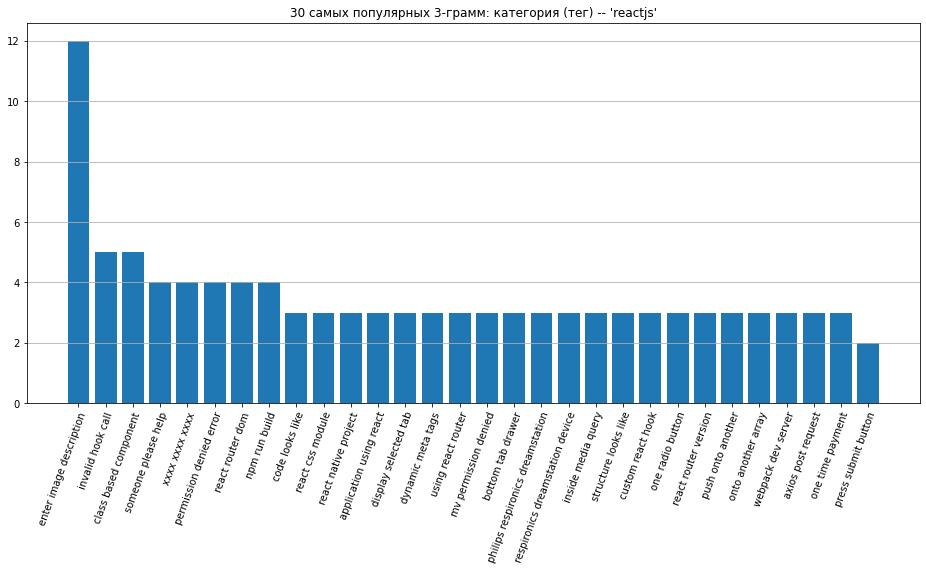

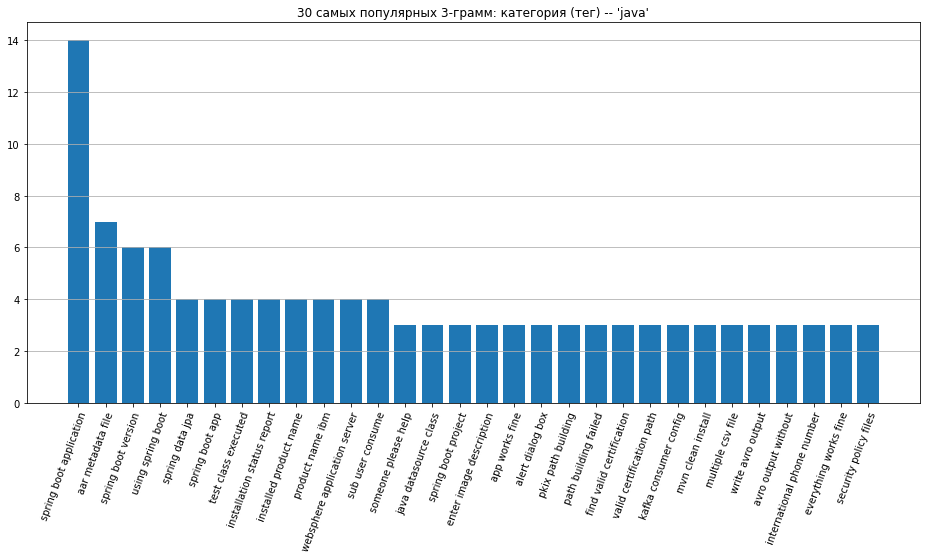

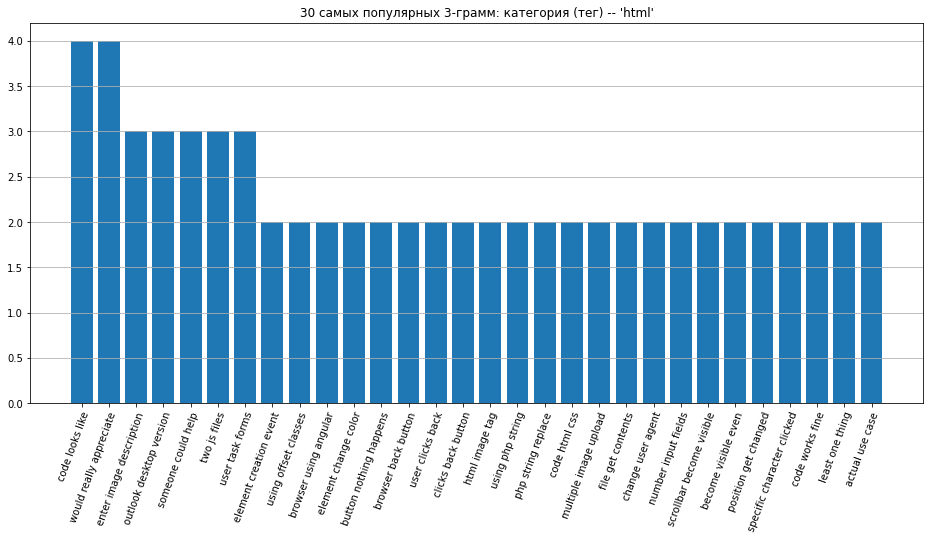

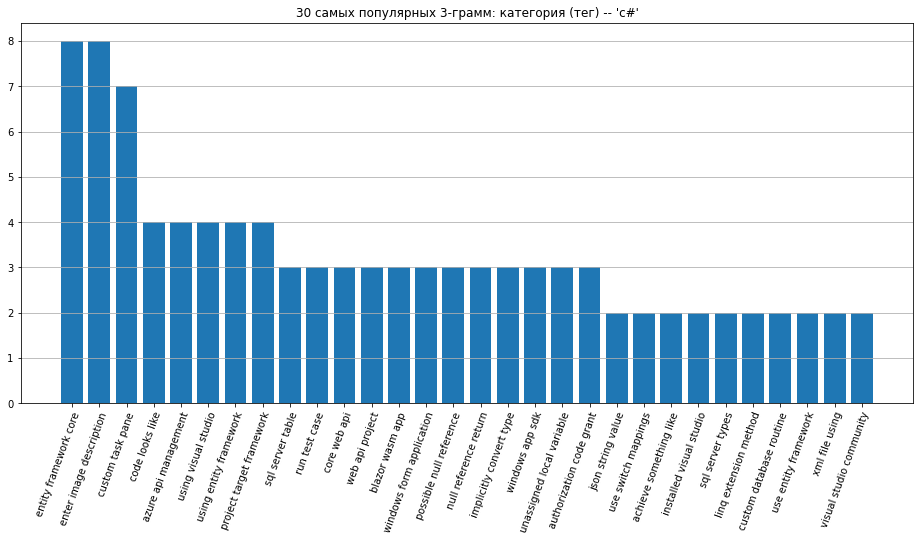

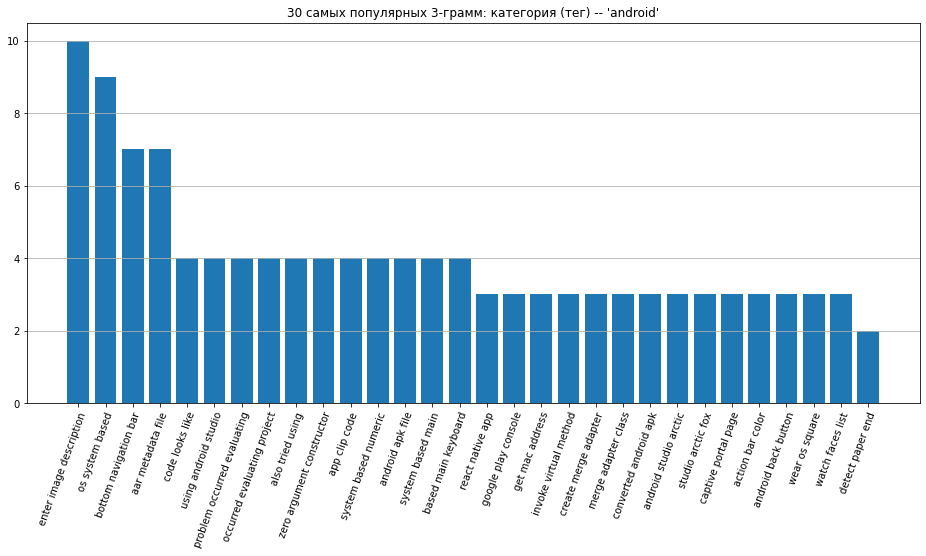

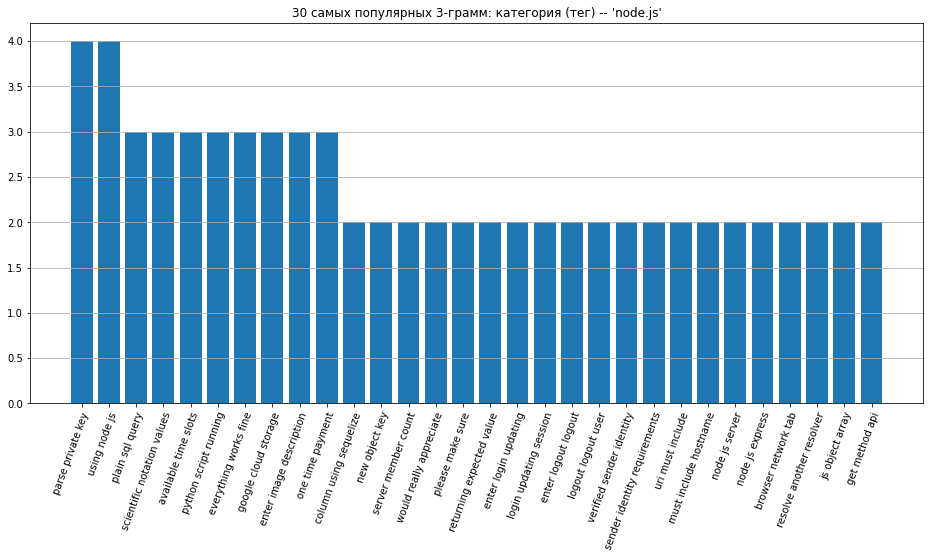

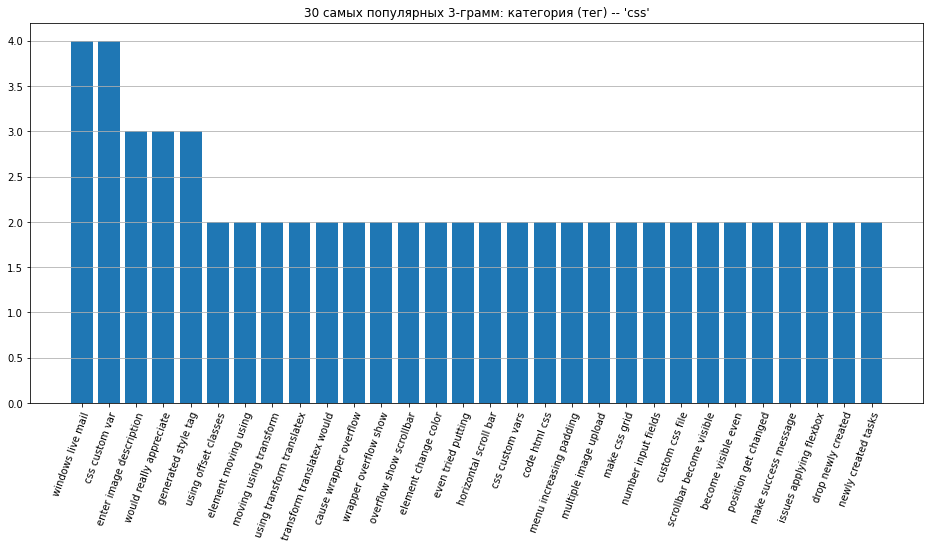

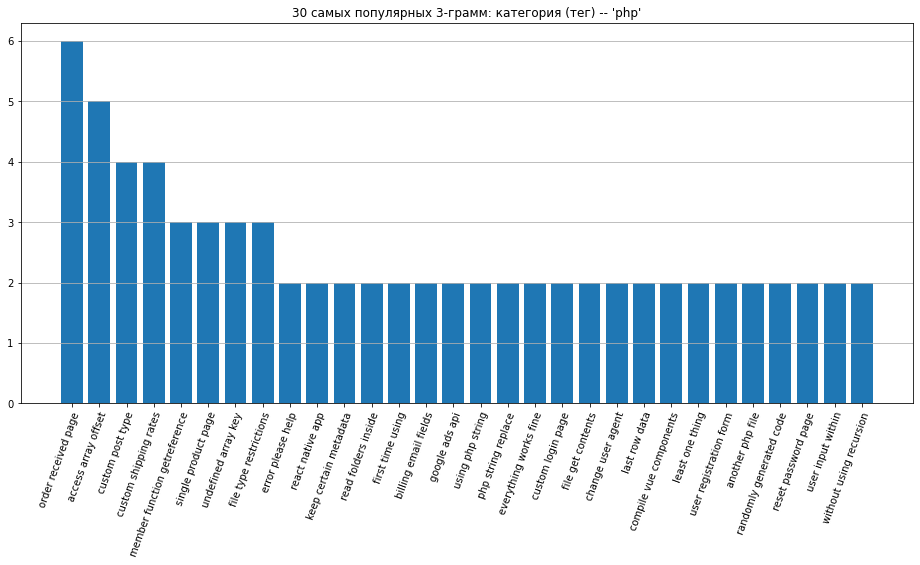

In [9]:
N = 3
fdist = nltk.FreqDist(
    " ".join(ngram_lower)
    for _, row in texts_data.iterrows()
    for ngram in nltk.ngrams(nltk.tokenize.word_tokenize(row["title"] + "\n" + row["text"]), N)
    if not set(ngram_lower := [w.lower() for w in ngram]) & STOP_WORDS
    and all(w.isalpha() for w in ngram_lower)
)
n = 30
draw_words_bar(get_most_frequent(fdist, n), f"{n} самых популярных {N}-грамм: без деления на теги")
for tag in most_frequent_tags:
    fdist = get_tagged_Ngramms_freq(tag, texts_data, N)
    draw_words_bar(get_most_frequent(fdist, n), f"{n} самых популярных {N}-грамм: категория (тег) -- '{tag}'")

При рассмотрении частот 2-грамм и 3-грамм видно, что даже без разделения на теги топ слов содержит довольно много специфичных фраз, которые, надо сказать, в большинстве случаев являются просто неделимыми общеупотребимыми терминами (`visual studio`, `sql server`, `csv file`, `visual studio code`, `django rest framework`, 

Разделение текстов на теги, как видно по диаграммам, существенно насыщает топы интересными и специфичными данному тегу фразами.